# Titanic

Équipe : Vincent Boettcher et lui même.

## Analyse et visualisation des données

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Création du dataframe
datanic_origin = pd.read_csv('Data/train.csv')
datanic_origin.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
# Copie du dataframe
datanic = datanic_origin.copy()

In [4]:
# Forme et infos du dataframe
print(f"Forme de la base de données: \n {datanic.shape}\n")
print(f"Nom des colonnes: \n {datanic.columns}\n")
print(f"Forme de la base de données: \n {datanic.info()}")

Forme de la base de données: 
 (891, 12)

Nom des colonnes: 
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Forme de la base de données:

In [5]:
def incomplete(data):
    total_incomplete = data[:].isnull().sum()
    return total_incomplete

datanic.apply(incomplete, axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Suppression de la colonne "Cabin" : trop de données manquantes

del datanic['Cabin']
datanic.apply(incomplete, axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

In [7]:
# Suppression de la colonne "Ticket" car le numéro du ticket n'est pas une donnée pertinente

del datanic['Ticket']
datanic.apply(incomplete, axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [8]:
# Drop des lignes aux données manquantes

datanic.dropna(axis = 0, subset = ["Age", "Embarked"], inplace=True)

In [9]:
# Création d'une colonne pour la répartition d'âge classée par "Minor, Adult, Senior"

def sort_age(line):
    age_label = line['Age']
    if line['Age'] < 18:
        return 'Minor'
    elif line['Age'] >= 18 :
        return 'Adult'
    else :
        return 'Unknown'
    
datanic["Age_label"] = datanic.apply(sort_age, axis = 1)
datanic.loc[:,["Pclass", "Name", "Sex", "Age", "Age_label", "Survived"]].head()

,Pclass,Name,Sex,Age,Age_label,Survived
0,3,"Braund, Mr. Owen Harris",male,22.0,Adult,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,Adult,1
2,3,"Heikkinen, Miss. Laina",female,26.0,Adult,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,Adult,1
4,3,"Allen, Mr. William Henry",male,35.0,Adult,0


In [10]:
datanic["Age_Sex"] = datanic.loc[:, "Age_label"] + " " + datanic.loc[:, "Sex"]
datanic.loc[:,["Pclass", "Name", "Sex", "Age_Sex", "Age", "Age_label", "Survived"]].head()

,Pclass,Name,Sex,Age_Sex,Age,Age_label,Survived
0,3,"Braund, Mr. Owen Harris",male,Adult male,22.0,Adult,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Adult female,38.0,Adult,1
2,3,"Heikkinen, Miss. Laina",female,Adult female,26.0,Adult,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Adult female,35.0,Adult,1
4,3,"Allen, Mr. William Henry",male,Adult male,35.0,Adult,0


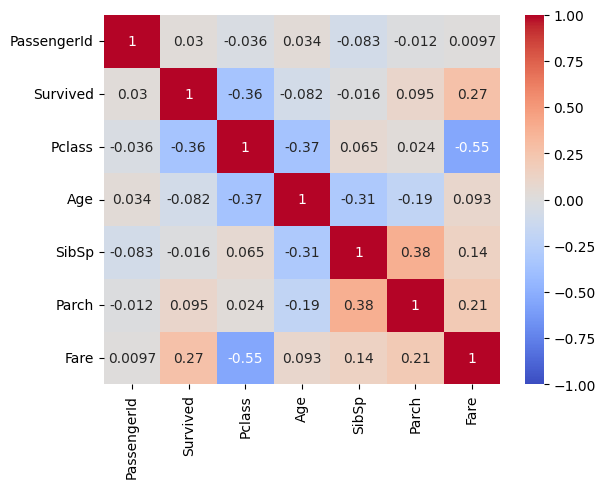

In [11]:
import warnings
warnings.filterwarnings('ignore')

# Matrice de corrélation entre les variables numériques du dataframe
plt.show(sns.heatmap(datanic.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm'))

In [12]:
datanic_small = datanic.loc[:, ["Pclass", "Sex", "Age_label", "Age_Sex", "Survived"]]
datanic_small

,Pclass,Sex,Age_label,Age_Sex,Survived
0,3,male,Adult,Adult male,0
1,1,female,Adult,Adult female,1
2,3,female,Adult,Adult female,1
3,1,female,Adult,Adult female,1
4,3,male,Adult,Adult male,0
...,...,...,...,...,...
885,3,female,Adult,Adult female,0
886,2,male,Adult,Adult male,0
887,1,female,Adult,Adult female,1
889,1,male,Adult,Adult male,1


In [13]:
datanic_medium = datanic.loc[:, ["Embarked", "Pclass", "Sex", "Age_Sex", "Age", "Age_label", "Survived"]]
datanic_medium

,Embarked,Pclass,Sex,Age_Sex,Age,Age_label,Survived
0,S,3,male,Adult male,22.0,Adult,0
1,C,1,female,Adult female,38.0,Adult,1
2,S,3,female,Adult female,26.0,Adult,1
3,S,1,female,Adult female,35.0,Adult,1
4,S,3,male,Adult male,35.0,Adult,0
...,...,...,...,...,...,...,...
885,Q,3,female,Adult female,39.0,Adult,0
886,S,2,male,Adult male,27.0,Adult,0
887,S,1,female,Adult female,19.0,Adult,1
889,C,1,male,Adult male,26.0,Adult,1


## Exploration des données

Observation de la répartition par catégories

In [14]:
print(f"Répartition des personnes par classe : \n{datanic.loc[:, 'Pclass'].value_counts()}\n")
print(f"Répartition des personnes par genre : \n{datanic.loc[:, 'Sex'].value_counts()}\n")
print(f"Répartition des personnes par âge (adulte/mineur) : \n{datanic.loc[:, 'Age_label'].value_counts()}\n")
print(f"Nombre de personnes décédées (0) et de survivants (1): \n{datanic.loc[:, 'Survived'].value_counts()}\n")
print(f"Répartition des personnes par lieu d'embarquement : \n{datanic.loc[:, 'Embarked'].value_counts()}")

Répartition des personnes par classe : 
3    355
1    184
2    173
Name: Pclass, dtype: int64

Répartition des personnes par genre : 
male      453
female    259
Name: Sex, dtype: int64

Répartition des personnes par âge (adulte/mineur) : 
Adult    599
Minor    113
Name: Age_label, dtype: int64

Nombre de personnes décédées (0) et de survivants (1): 
0    424
1    288
Name: Survived, dtype: int64

Répartition des personnes par lieu d'embarquement : 
S    554
C    130
Q     28
Name: Embarked, dtype: int64


### Est-ce que la classe et le genre influencent les chances de survie?

In [15]:
# Chances de survie par classe

datanic.pivot_table(index = "Pclass", values = ["Survived"], aggfunc = [np.mean,sum])

,mean,sum
,Survived,Survived
Pclass,,
1,0.652174,120
2,0.479769,83
3,0.239437,85


In [16]:
# Chances de survie par genre (non binaire exclu) et total

datanic.pivot_table(index=["Sex"], values = ["Survived"], aggfunc = [np.mean,sum])

,mean,sum
,Survived,Survived
Sex,,
female,0.752896,195
male,0.205298,93


In [17]:
# Chances de survie par classe et par genre et total

datanic.pivot_table(index = ["Pclass", "Sex"], values = ["Survived"], aggfunc = [np.mean,sum])

mean      sum
               Survived Survived
Pclass Sex                      
1      female  0.963855       80
       male    0.396040       40
2      female  0.918919       68
       male    0.151515       15
3      female  0.460784       47
       male    0.150198       38

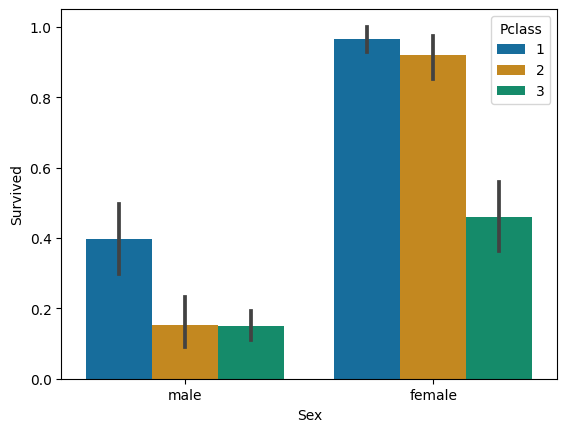

In [18]:
sns.barplot(data=datanic_small, x="Sex", y="Survived",hue="Pclass", palette="colorblind", estimator='mean')
plt.show()

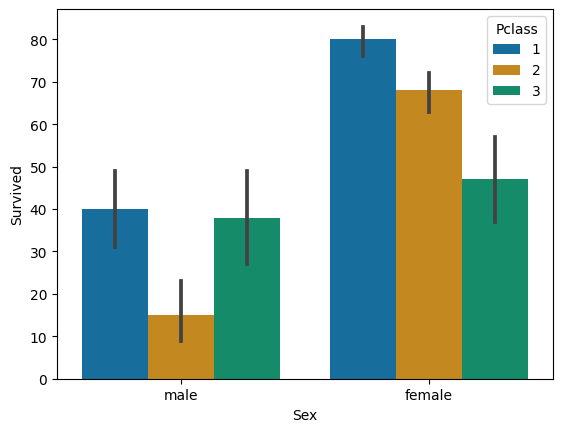

In [19]:
sns.barplot(data=datanic_small, x="Sex", y="Survived",hue="Pclass", palette="colorblind", estimator='sum')
plt.show()

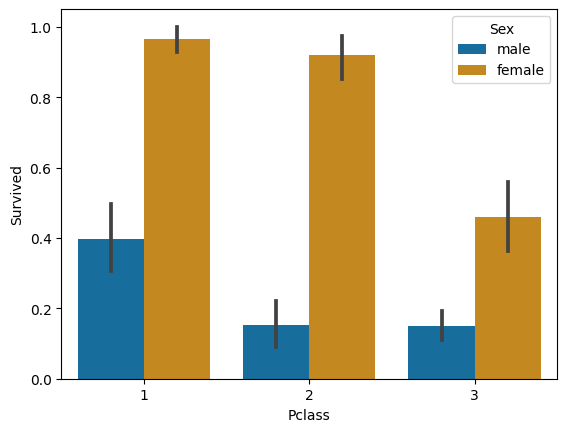

In [20]:
sns.barplot(data=datanic_small, x="Pclass", y="Survived", hue="Sex", palette="colorblind", estimator='mean')
plt.show()

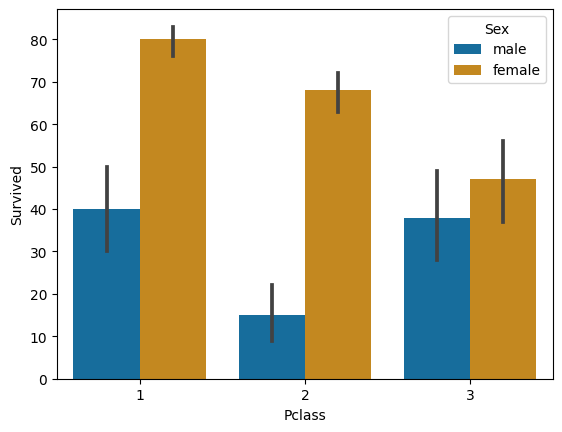

In [21]:
sns.barplot(data=datanic_small, x="Pclass", y="Survived", hue="Sex", palette="colorblind", estimator='sum')
plt.show()

Les deux critères de classe et de genre semblent très discriminants dans la mesure du taux de survie des passagers.
Si on faisait un classement des personnes ayant davantage survécu, le résultat parle de lui-même :
1. Femme en 1ère classe
2. Femme en 2ème classe
3. Femme en 3ème classe
4. Homme en 1ère classe
5. Homme en 2ème classe
6. Homme en 3ème classe

On va explorer le reste des données pour essayer de voir s'il y a d'autres critères discriminants dans le taux de survie.

### Est-ce que le lieu d'embarquement influence les chances de survie?

In [22]:
# Survie par lieu d'embarquement

datanic.pivot_table(index=["Embarked"], values = ["Survived"], aggfunc = [np.mean,sum])

,mean,sum
,Survived,Survived
Embarked,,
C,0.607692,79
Q,0.285714,8
S,0.362816,201


In [23]:
datanic.loc[:, "Embarked"].value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

In [24]:
datanic.groupby('Embarked').Survived.value_counts()

Embarked  Survived
C         1            79
          0            51
Q         0            20
          1             8
S         0           353
          1           201
Name: Survived, dtype: int64

In [25]:
datanic.groupby('Embarked').Pclass.value_counts()

Embarked  Pclass
C         1          74
          3          41
          2          15
Q         3          24
          1           2
          2           2
S         3         290
          2         156
          1         108
Name: Pclass, dtype: int64

Plusieurs données intéressantes sont à prendre en compte:
- Le lieu d'embarquement "Q" pour Queenstown en Irlande a été principalement utilisé par des personnes voyageant en 3ème classe. Seulement 2 personnes étaient en 1ère, 2 personnes en 2ème contre 24 personnes en 3ème.
- L'embarquement "C" pour Cherbourg en France a été principalement utilisé par des personnes voyegant en 1ère classe : 74 personnes contre seulement 15 pour la 2ème classe et 41 pour la 3ème classe. La catégorie "C" est donc davantage représentée par des personnes de 1ère classe alors que pour "Q" et "S" la 1ère classe est souvent la catégorie ayant le moins de voyageurs.

In [26]:
# Survie par lieu d'embarquement et par classe
datanic.pivot_table(index=["Embarked", "Pclass"], values = ["Survived"], aggfunc = [np.mean,sum])

mean      sum
                 Survived Survived
Embarked Pclass                   
C        1       0.716216       53
         2       0.533333        8
         3       0.439024       18
Q        1       0.500000        1
         2       0.500000        1
         3       0.250000        6
S        1       0.611111       66
         2       0.474359       74
         3       0.210345       61

In [27]:
# Survie par lieu d'embarquement et par genre
datanic.pivot_table(index=["Embarked", "Sex"], values = ["Survived"], aggfunc = [np.mean,sum])

mean      sum
                 Survived Survived
Embarked Sex                      
C        female  0.901639       55
         male    0.347826       24
Q        female  0.583333        7
         male    0.062500        1
S        female  0.715054      133
         male    0.184783       68

Pour "Q" : 
- 1ère et 2ème classe, seulement 2 personnes par classe et un taux de survie de 50% par classe. La moyenne n'est pas pertinente sur si peu de données.

Pour "C" :
- Le % de survie en 3ème classe est de 43%, supérieur à ceux de "Q" et "S", respectivement "25% et 21%". A voir si cela se justifie par une plus grande part de femmes dans le groupe "C"?

In [28]:
datanic.groupby('Embarked').Sex.value_counts()

Embarked  Sex   
C         male       69
          female     61
Q         male       16
          female     12
S         male      368
          female    186
Name: Sex, dtype: int64

La répartition par genre hors classe est plutôt homogène pour "Q" et "C", mais hétérogène pour "S". Il y a beaucoup plus d'hommes que de femmes ce qui peut aider à expliquer le taux de survie inférieur pour les personnes ayant embarqué à Southampton par rapport à Cherbourg ou Queenstown.

In [29]:
# Survie par lieu d'embarquement, par classe et par genre

datanic.pivot_table(index=["Embarked", "Pclass", "Sex"], values = ["Survived"], aggfunc = [np.mean,sum])

mean      sum
                        Survived Survived
Embarked Pclass Sex                      
C        1      female  0.973684       37
                male    0.444444       16
         2      female  1.000000        7
                male    0.125000        1
         3      female  0.687500       11
                male    0.280000        7
Q        1      female  1.000000        1
                male    0.000000        0
         2      female  1.000000        1
                male    0.000000        0
         3      female  0.500000        5
                male    0.071429        1
S        1      female  0.954545       42
                male    0.375000       24
         2      female  0.909091       60
                male    0.155556       14
         3      female  0.407895       31
                male    0.140187       30

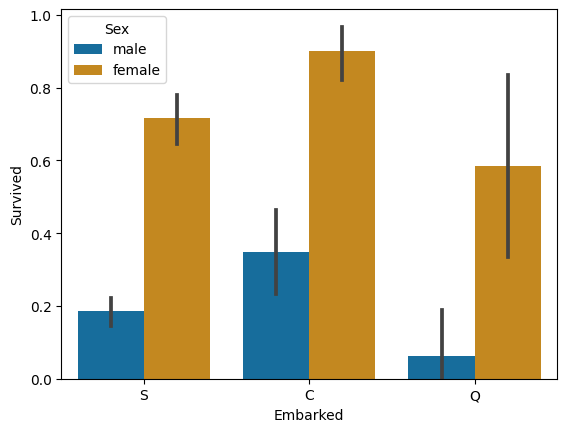

In [30]:
sns.barplot(data=datanic_medium, x="Embarked", y="Survived", hue="Sex", palette="colorblind", estimator='mean')
plt.show()

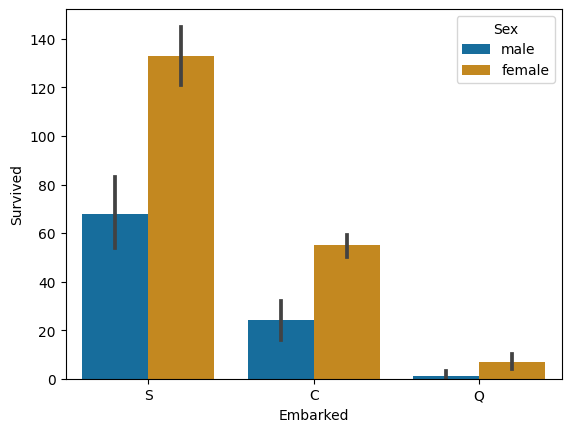

In [31]:
sns.barplot(data=datanic_medium, x="Embarked", y="Survived", hue="Sex", palette="colorblind", estimator='sum')
plt.show()

On retrouve la même constante : les femmes ont davantage survécu que les hommes, qu'importe le lieu d'embarquement.
La différence entre les 3 catégories se situe plus dans la répartition des classes :
- Il y a plus de personnes en 1ère classe pour Cherbourg
- Il y a presque uniquement des personnes en 3ème classe pour Queenstown.

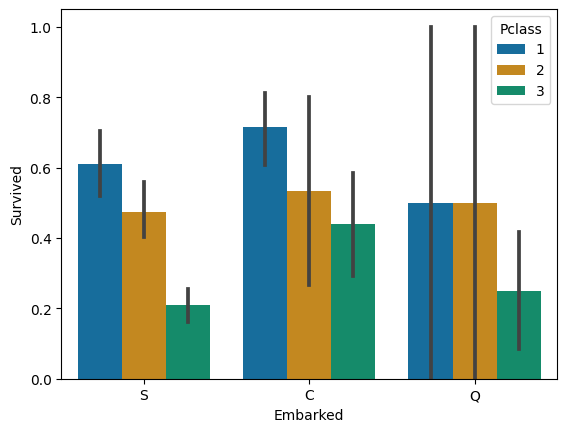

In [32]:
sns.barplot(data=datanic_medium, x="Embarked", y="Survived", hue="Pclass", palette="colorblind", estimator="mean")
plt.show()

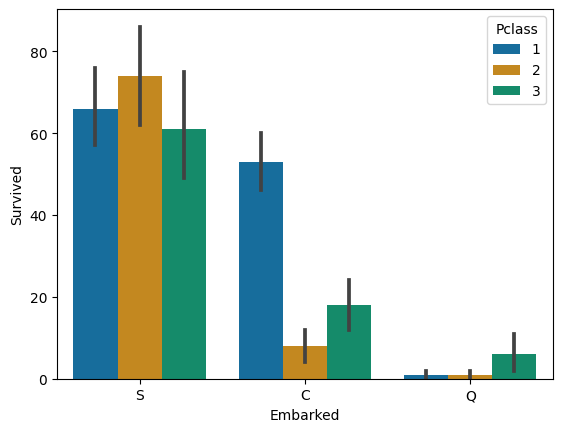

In [33]:
sns.barplot(data=datanic_medium, x="Embarked", y="Survived", hue="Pclass", palette="colorblind", estimator="sum")
plt.show()

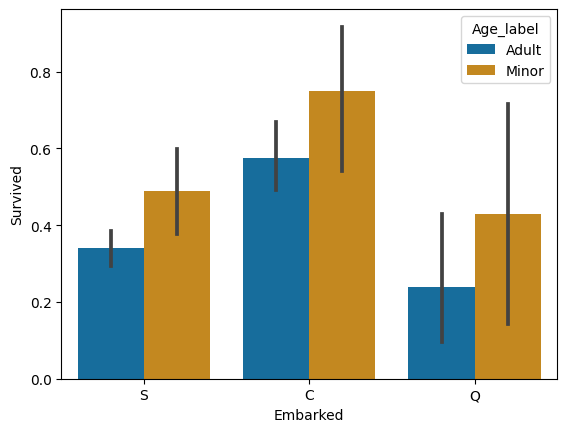

In [34]:
sns.barplot(data=datanic_medium, x="Embarked", y="Survived", hue="Age_label", palette="colorblind", estimator="mean")
plt.show()

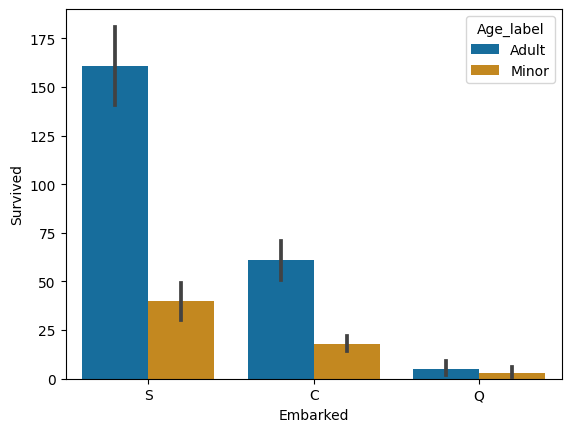

In [35]:
sns.barplot(data=datanic_medium, x="Embarked", y="Survived", hue="Age_label", palette="colorblind", estimator="sum")
plt.show()

Le taux de survie semble donc toujours plus lié à deux critières:
- la classe du voyageur
- le genre

Y a t'il d'autres critères discriminants?

### Est-ce que l'âge et la distinction adulte/mineur influencent les chances de survie?

In [36]:
datanic.pivot_table(index=["Age_label"], values = ["Survived"], aggfunc = [np.mean,sum])

,mean,sum
,Survived,Survived
Age_label,,
Adult,0.378965,227
Minor,0.539823,61


In [37]:
datanic.pivot_table(index=["Age_label", "Sex"], values = ["Survived"], aggfunc = [np.mean,sum])

mean      sum
                  Survived Survived
Age_label Sex                      
Adult     female  0.769608      157
          male    0.177215       70
Minor     female  0.690909       38
          male    0.396552       23

In [38]:
datanic.pivot_table(index=["Age_label", "Sex", "Pclass"], values = ["Survived"], aggfunc = [np.mean,sum])

mean      sum
                         Survived Survived
Age_label Sex    Pclass                   
Adult     female 1       0.973333       73
                 2       0.903226       56
                 3       0.417910       28
          male   1       0.371134       36
                 2       0.068182        6
                 3       0.133333       28
Minor     female 1       0.875000        7
                 2       1.000000       12
                 3       0.542857       19
          male   1       1.000000        4
                 2       0.818182        9
                 3       0.232558       10

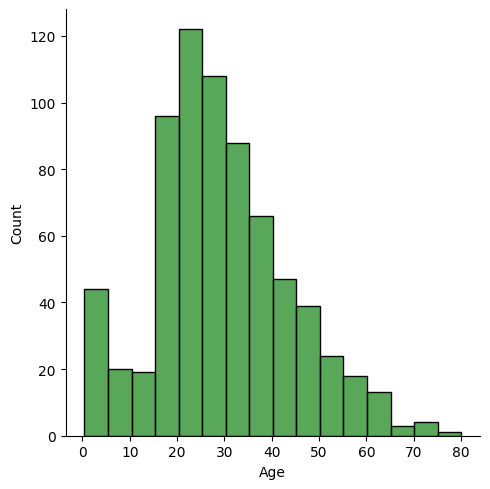

In [39]:
# Répartition par âge des passagers
vis1 = sns.displot(datanic['Age'], bins=16, color="forestgreen")


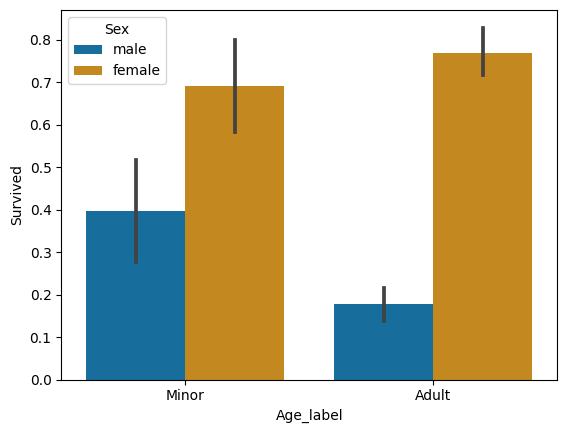

In [40]:
sns.barplot(data=datanic_medium, x="Age_label", y="Survived", hue="Sex", palette="colorblind", estimator="mean",
            order = ["Minor", "Adult"])
plt.show()

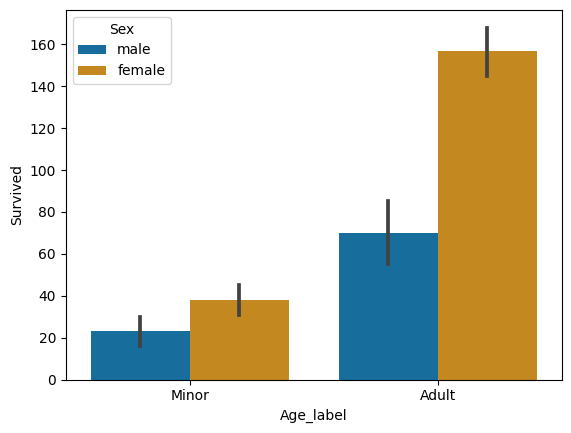

In [41]:
sns.barplot(data=datanic_medium, x="Age_label", y="Survived", hue="Sex", palette="colorblind", estimator="sum",
            order = ["Minor", "Adult"])
plt.show()

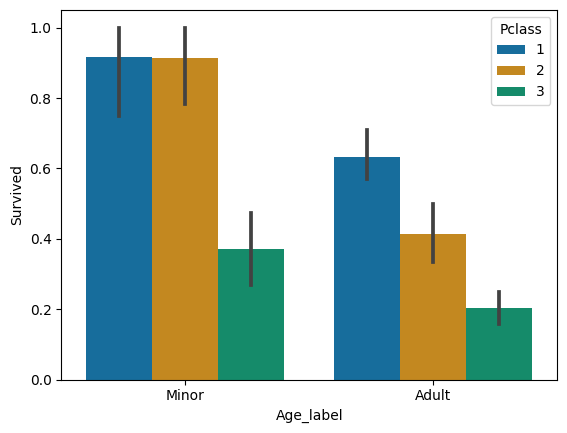

In [42]:
sns.barplot(data=datanic_medium, x="Age_label", y="Survived", hue="Pclass", palette="colorblind", estimator="mean",
            order = ["Minor", "Adult"])
plt.show()

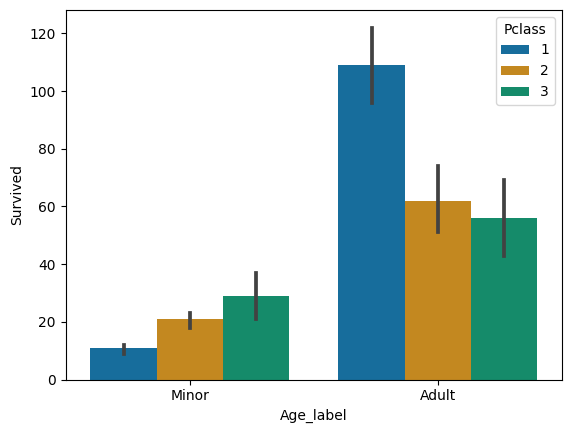

In [43]:
sns.barplot(data=datanic_medium, x="Age_label", y="Survived", hue="Pclass", palette="colorblind", estimator="sum",
            order = ["Minor", "Adult"])
plt.show()

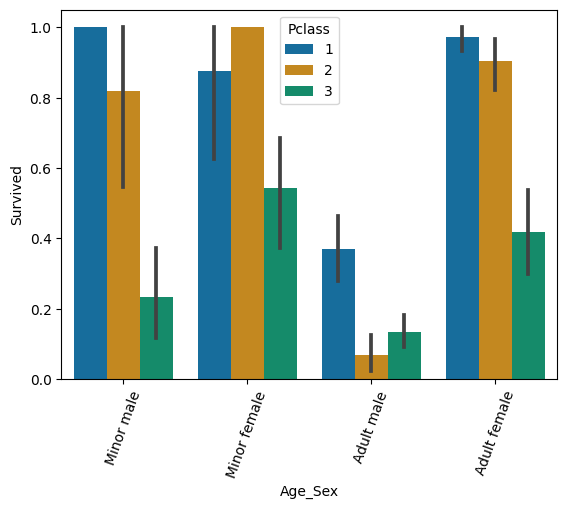

In [44]:
sns.barplot(data=datanic_medium, x="Age_Sex", y="Survived", hue="Pclass", palette="colorblind",
            order = ["Minor male", "Minor female", "Adult male", "Adult female"])
plt.xticks(rotation=70)
plt.show()

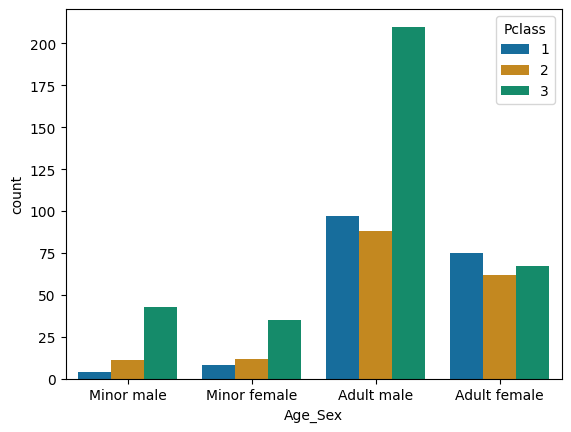

In [45]:
sns.countplot(data=datanic_small, x="Age_Sex", hue="Pclass", palette="colorblind",
              order = ["Minor male", "Minor female", "Adult male", "Adult female"])
plt.show()

Le critère mineur/majeur réduit l'écart dans le taux de survie entre garçons et filles mais le taux de survie est toujours supérieur pour les filles (+/- 70%) que pour les garçons (+/- 39%). Les mineurs ont en tout cas un taux de survie supérieur aux adultes. A noter toutefois que l'échantillon pour les mineurs est moindre que pour les adultes.

Ce critère reste donc discriminatoire et peut être ajouté à ceux de classe et de genre pour étudier le taux de survie d'un passager.

### Est-ce que les chances de survie sont plus élevées quand on a payé son billet plus cher?

In [46]:
datanic.pivot_table(index=["Pclass"], values = ["Fare", "Survived"], aggfunc = [np.mean])

mean          
             Fare  Survived
Pclass                     
1       88.048121  0.652174
2       21.471556  0.479769
3       13.229435  0.239437

In [47]:
datanic.pivot_table(index=["Pclass", "Sex"], values = ["Fare", "Survived"], aggfunc = [np.mean])

mean          
                     Fare  Survived
Pclass Sex                         
1      female  108.619680  0.963855
       male     71.142781  0.396040
2      female   21.951070  0.918919
       male     21.113131  0.151515
3      female   15.875369  0.460784
       male     12.162695  0.150198

In [48]:
datanic.pivot_table(index=["Pclass", "Age_Sex"], values = ["Fare", "Survived"], aggfunc = [np.mean])

mean          
                           Fare  Survived
Pclass Age_Sex                           
1      Adult female  109.103556  0.973333
       Adult male     69.289993  0.371134
       Minor female  104.083337  0.875000
       Minor male    116.072900  1.000000
2      Adult female   21.120632  0.903226
       Adult male     20.544839  0.068182
       Minor female   26.241667  1.000000
       Minor male     25.659473  0.818182
3      Adult female   14.385200  0.417910
       Adult male      9.994302  0.133333
       Minor female   18.727977  0.542857
       Minor male     22.752523  0.232558

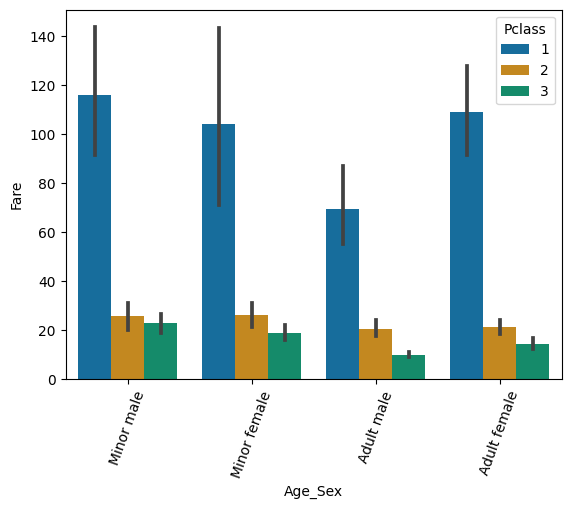

In [49]:
sns.barplot(data=datanic, x="Age_Sex", y="Fare", hue="Pclass", palette="colorblind",
            order = ["Minor male", "Minor female", "Adult male", "Adult female"])
plt.xticks(rotation=70)
plt.show()

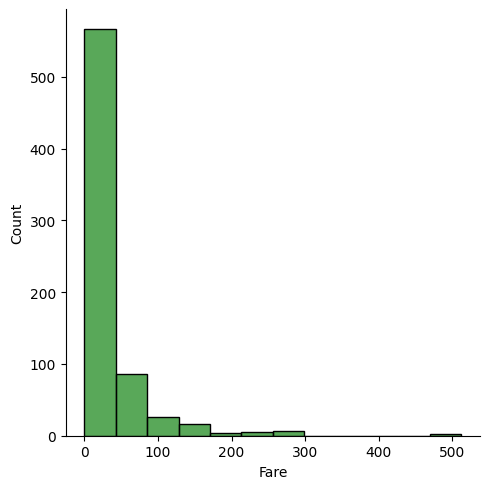

In [50]:
sns.displot(datanic['Fare'], bins=12, color="forestgreen")

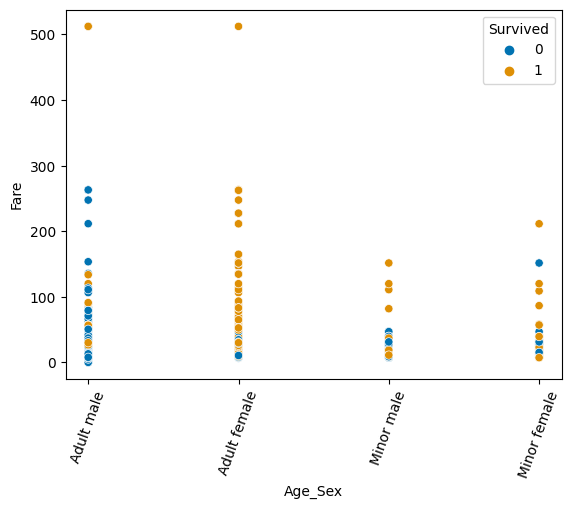

In [51]:
sns.scatterplot(data=datanic, x="Age_Sex", y="Fare", hue="Survived", palette="colorblind")
plt.xticks(rotation=70)
plt.show()

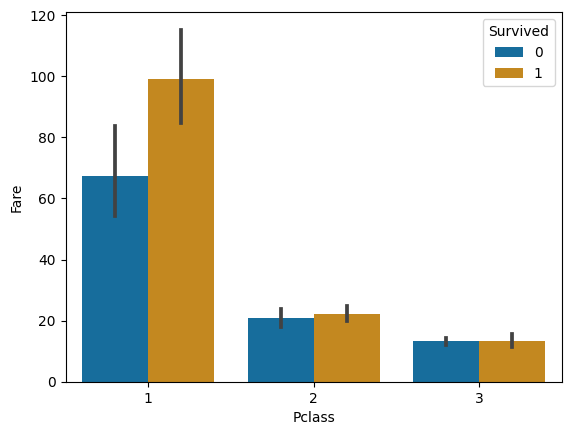

In [52]:
sns.barplot(data=datanic, x="Pclass", y="Fare", hue="Survived", palette="colorblind")
plt.show()

Un prix du ticket élevé semble augmenter les chances de survie mais il est peut être lié au port de départ ainsi qu'à la classe du voyageur.

## Algorithme de classification

### Imports nécessaires de scikit-learn

In [53]:
from sklearn import datasets, svm, metrics, model_selection, preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

### Préparation de la base de données

In [177]:
datanic_encoded = datanic.copy()
datanic_encoded = datanic_encoded.drop(['PassengerId', 'Name', 'Age_Sex', 'SibSp', 'Parch'], axis=1)

encoder = LabelBinarizer()
datanic_encoded['Sex'] = encoder.fit_transform(datanic_encoded['Sex'])
datanic_encoded['Embarked'] = encoder.fit_transform(datanic_encoded['Embarked'])
datanic_encoded['Age_label'] = encoder.fit_transform(datanic_encoded['Age_label'])

datanic_encoded.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Age_label
0,0,3,1,22.0,7.2500,0,0
1,1,1,0,38.0,71.2833,1,0
2,1,3,0,26.0,7.9250,0,0
3,1,1,0,35.0,53.1000,0,0
4,0,3,1,35.0,8.0500,0,0
6,0,1,1,54.0,51.8625,0,0
7,0,3,1,2.0,21.0750,0,1
8,1,3,0,27.0,11.1333,0,0
9,1,2,0,14.0,30.0708,1,1
10,1,3,0,4.0,16.7000,0,1


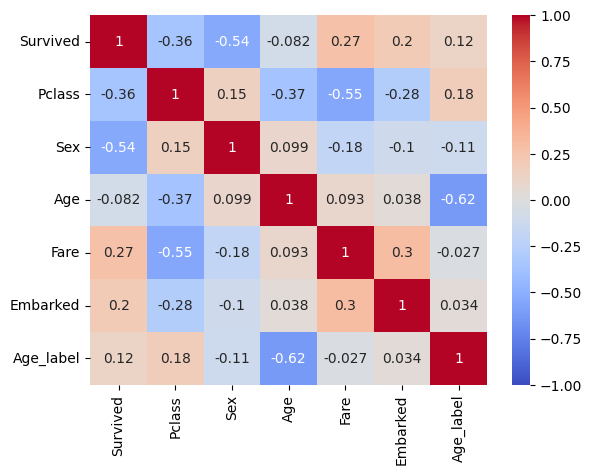

In [55]:
# Matrice de corrélation entre les variables numériques du dataframe nettoyé avant normalisation et algo
# Les valeurs de corrélation sont comprises entre -1 et +1.

plt.show(sns.heatmap(datanic_encoded.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm'))

In [56]:
# On sépare les features du target 
features, target = datanic_encoded.loc[:, 'Pclass':'Age_label'], datanic_encoded["Survived"]

# On split notre dataframe en 2
feat_train, feat_test, target_train, target_test = train_test_split(features, target)

# On normalise
scaler = MinMaxScaler()
feat_train = scaler.fit_transform(feat_train)
feat_test = scaler.transform(feat_test)

### SVC linear

In [57]:
# On initalise le modèle 
svc_classifier_linear = svm.SVC(kernel='linear', C=1.0)

# On l'entraîne sur nos données d'entraînement
svc_classifier_linear.fit(feat_train, target_train)

# On l'utilise pour prédire sur les données de test
predict = svc_classifier_linear.predict(feat_test)

# Metrics du modèle : accuracy, recall, precision, f1 score
print(accuracy_score(target_test, predict))
print(recall_score(target_test, predict))
print(precision_score(target_test, predict))
print(f1_score(target_test, predict))

# Matrice de confusion
print(confusion_matrix(target_test, predict))

0.7865168539325843
0.7397260273972602
0.7397260273972602
0.7397260273972603
[[86 19]
 [19 54]]


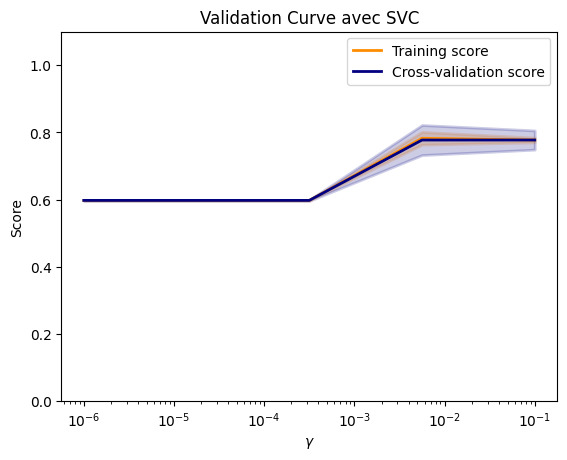

In [58]:
param_range = np.logspace(-6, -1, 5)

train_scores, valid_scores = validation_curve(SVC(), feat_train, target_train, param_name="gamma", 
                                              param_range=param_range)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve avec SVC")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

### SVC rbf

0.848314606741573
0.6712328767123288
0.9423076923076923
0.784


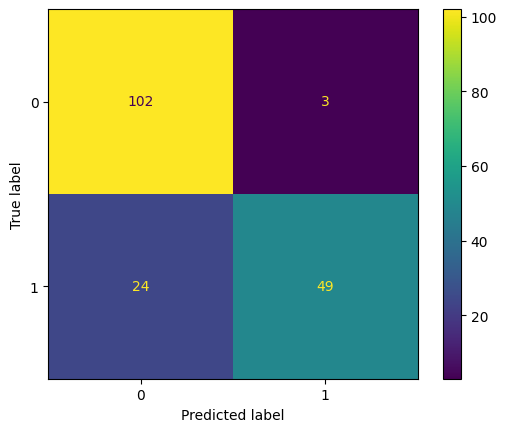

In [59]:
# On initalise le modèle 
svc_classifier_rbf = svm.SVC(kernel='rbf', C=1.0)

# On l'entraîne sur nos données d'entraînement
svc_classifier_rbf.fit(feat_train, target_train)


# On l'utilise pour prédire sur les données de test
predict = svc_classifier_rbf.predict(feat_test)

# Metrics du modèle : accuracy, recall, precision, f1 score
print(accuracy_score(target_test, predict))
print(recall_score(target_test, predict))
print(precision_score(target_test, predict))
print(f1_score(target_test, predict))

# Matrice de confusion
plt.show(ConfusionMatrixDisplay.from_estimator(svc_classifier_rbf, feat_test, target_test))

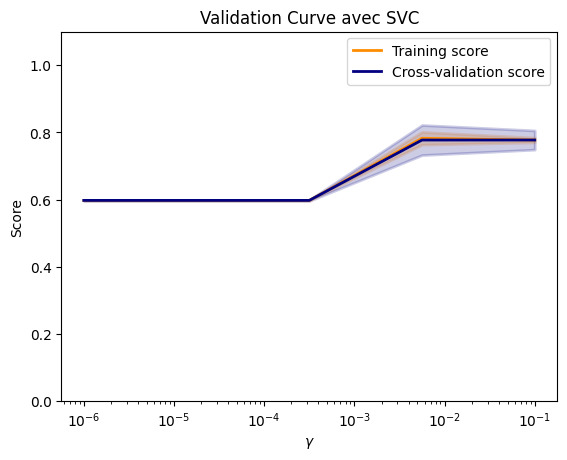

In [60]:
param_range = np.logspace(-6, -1, 5)

train_scores, valid_scores = validation_curve(svc_classifier_rbf, feat_train, target_train, param_name="gamma", 
                                              param_range=param_range)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve avec SVC")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

### SVC avec GridSearchCV

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Résultats de la validation croisée :

accuracy = 0.777 (+/-0.057) for {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
accuracy = 0.779 (+/-0.059) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
accuracy = 0.775 (+/-0.076) for {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
accuracy = 0.777 (+/-0.057) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
accuracy = 0.777 (+/-0.057) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy = 0.597 (+/-0.003) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
accuracy = 0.777 (+/-0.057) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
accuracy = 0.597 (+/-0.003) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
accuracy = 0.597 (+/-0.003) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
accuracy = 0.777 (+/-0.057) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
accuracy = 0.597 (+/-0.003) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
accuracy = 0.597 (+/-0.003) for {'C': 0.1, 'gamma': 0.001, 'kernel': '

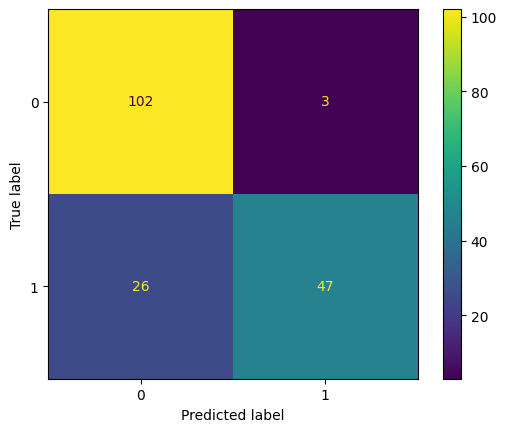

In [61]:
# On fixe les valeurs des hyperparamètres à tester
parameters = {'C':[0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel':('linear', 'rbf', 'poly')}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur SVC avec recherche d'hyperparamètre par validation croisée
svc = svm.SVC(gamma="scale")
svc_classifier = model_selection.GridSearchCV(svc, parameters, verbose = 1)

# On l'entraîne sur nos données d'entraînement
svc_classifier.fit(feat_train, target_train)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :\n")
for mean, std, params in zip(svc_classifier.cv_results_['mean_test_score'], svc_classifier.cv_results_['std_test_score'],svc_classifier.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(score,mean,std*2,params))
    
y_pred = svc_classifier.predict(feat_test)
y_true = target_test

print('\n',classification_report(y_true, y_pred))

# Matrice de confusion
plt.show(ConfusionMatrixDisplay.from_estimator(svc_classifier, feat_test, target_test))

In [62]:
print(f"Best parameters : {svc_classifier.best_params_}\n")
print(f"Best score : {svc_classifier.best_score_}\n")
print(f"Best estimator : {svc_classifier.best_estimator_}")

Best parameters : {'C': 1, 'gamma': 1, 'kernel': 'poly'}

Best score : 0.7826485628636923

Best estimator : SVC(C=1, gamma=1, kernel='poly')


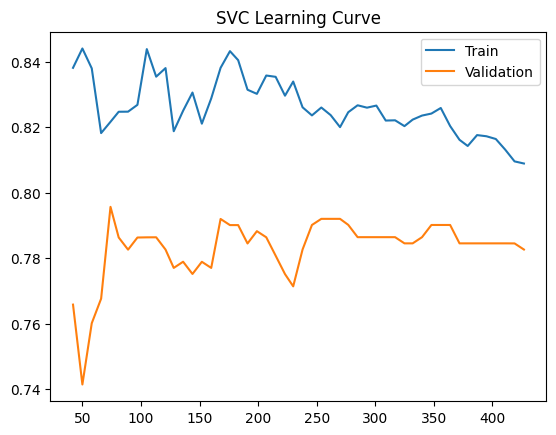

In [63]:
train_sizes, train_scores, valid_scores = learning_curve(svc_classifier.best_estimator_, feat_train, target_train, train_sizes=np.linspace(0.1, 1, 50), cv=5)
    
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = "Train")
plt.plot(train_sizes,np.mean(valid_scores,axis=1), label = "Validation")
plt.title("SVC Learning Curve")
plt.legend()
plt.show()

### Comparaison des résultats avec un algorithme différent : KNN avec GridSearchCV

In [64]:
# Imports spécifiques à KNN
from sklearn import neighbors, metrics
from sklearn.neighbors import KNeighborsClassifier

Résultats de la validation croisée :

accuracy = 0.766 (+/-0.087) for {'n_neighbors': 2}
accuracy = 0.762 (+/-0.037) for {'n_neighbors': 3}
accuracy = 0.770 (+/-0.062) for {'n_neighbors': 4}
accuracy = 0.777 (+/-0.058) for {'n_neighbors': 5}
accuracy = 0.773 (+/-0.086) for {'n_neighbors': 6}
accuracy = 0.768 (+/-0.084) for {'n_neighbors': 7}
accuracy = 0.773 (+/-0.096) for {'n_neighbors': 8}
accuracy = 0.766 (+/-0.082) for {'n_neighbors': 9}
accuracy = 0.775 (+/-0.063) for {'n_neighbors': 10}
accuracy = 0.771 (+/-0.056) for {'n_neighbors': 11}
accuracy = 0.777 (+/-0.065) for {'n_neighbors': 12}
accuracy = 0.781 (+/-0.065) for {'n_neighbors': 13}
accuracy = 0.781 (+/-0.065) for {'n_neighbors': 14}
accuracy = 0.771 (+/-0.050) for {'n_neighbors': 15}
accuracy = 0.777 (+/-0.064) for {'n_neighbors': 16}
accuracy = 0.760 (+/-0.050) for {'n_neighbors': 17}
accuracy = 0.766 (+/-0.051) for {'n_neighbors': 18}
accuracy = 0.768 (+/-0.055) for {'n_neighbors': 19}
accuracy = 0.770 (+/-0.036) for {'

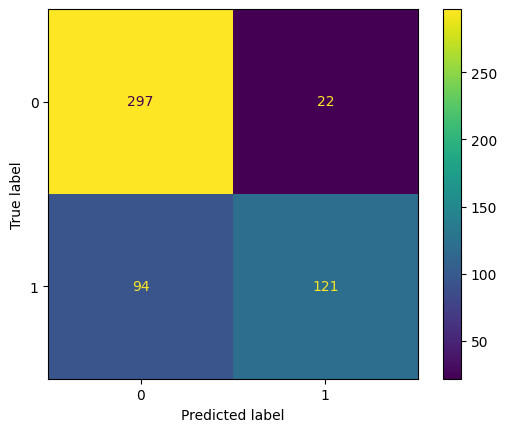


               precision    recall  f1-score   support

           0       0.76      0.93      0.84       319
           1       0.85      0.56      0.68       215

    accuracy                           0.78       534
   macro avg       0.80      0.75      0.76       534
weighted avg       0.79      0.78      0.77       534



In [65]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors': range(2,51)}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
knn_classifier = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester        
    scoring=score)   # score à optimiser

knn_classifier.fit(feat_train, target_train)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :\n")
for mean, std, params in zip(knn_classifier.cv_results_['mean_test_score'], knn_classifier.cv_results_['std_test_score'],knn_classifier.cv_results_['params']):
    print("{} = {:.3f} (+/-{:.03f}) for {}".format(score,mean,std*2,params))
    
y_pred = knn_classifier.predict(feat_train)
y_true = target_train

plt.show(ConfusionMatrixDisplay.from_estimator(knn_classifier, feat_train, target_train))

print('\n',classification_report(y_true, y_pred))

In [66]:
print(f"Best parameters : {knn_classifier.best_params_}\n")
print(f"Best score : {knn_classifier.best_score_}\n")
print(f"Best estimator : {knn_classifier.best_estimator_}")

Best parameters : {'n_neighbors': 48}

Best score : 0.7864221477693529

Best estimator : KNeighborsClassifier(n_neighbors=48)


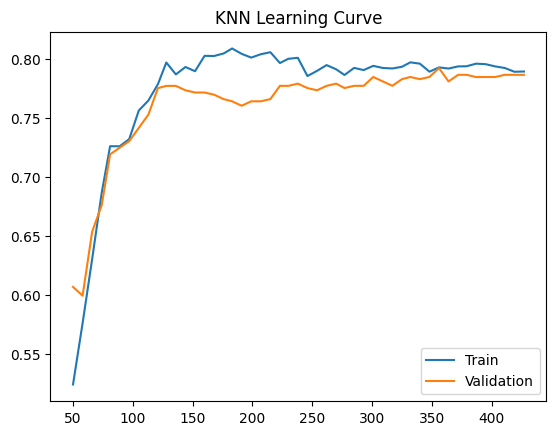

In [67]:
train_sizes, train_scores, valid_scores = learning_curve(knn_classifier.best_estimator_, feat_train, target_train, train_sizes=np.linspace(0.1, 1, 50), cv=5)
    
plt.plot(train_sizes,np.mean(train_scores,axis=1), label = "Train")
plt.plot(train_sizes,np.mean(valid_scores,axis=1), label = "Validation")
plt.title("KNN Learning Curve")
plt.legend()
plt.show()

Les résultats sont assez proches entre l'algo KNN en GridSearchCV et SVC en GridSearchCV.

Sur un même jeu de de données, SVC obtenait au mieux 80% d'accuracy là où KNN obtenait 79% d'accuracy.

### Algo avec pipelines

In [228]:
# Imports pour la pipeline

from sklearn import pipeline
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

In [216]:
# On copie le dataframe et on retire les colonnes non discriminantes
datanic_for_pipeline = datanic.copy()
datanic_for_pipeline.drop(['PassengerId', 'Name', 'SibSp', 'Parch'], axis = 1, inplace=True)
datanic_for_pipeline.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Age_label,Age_Sex
0,0,3,male,22.0,7.2500,S,Adult,Adult male
1,1,1,female,38.0,71.2833,C,Adult,Adult female
2,1,3,female,26.0,7.9250,S,Adult,Adult female
3,1,1,female,35.0,53.1000,S,Adult,Adult female
4,0,3,male,35.0,8.0500,S,Adult,Adult male


In [186]:
#datanic_encoded = datanic.copy()
#datanic_encoded = datanic_encoded.drop(['PassengerId', 'Name', 'Age_Sex', 'SibSp', 'Parch'], axis=1)

#encoder = LabelBinarizer()
#datanic_encoded['Sex'] = encoder.fit_transform(datanic_encoded['Sex'])
#datanic_encoded['Embarked'] = encoder.fit_transform(datanic_encoded['Embarked'])
#datanic_encoded['Age_label'] = encoder.fit_transform(datanic_encoded['Age_label'])

#datanic_encoded.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Age_label
0,0,3,1,22.0,7.2500,0,0
1,1,1,0,38.0,71.2833,1,0
2,1,3,0,26.0,7.9250,0,0
3,1,1,0,35.0,53.1000,0,0
4,0,3,1,35.0,8.0500,0,0
6,0,1,1,54.0,51.8625,0,0
7,0,3,1,2.0,21.0750,0,1
8,1,3,0,27.0,11.1333,0,0
9,1,2,0,14.0,30.0708,1,1
10,1,3,0,4.0,16.7000,0,1


In [221]:
numerical_pipeline = make_pipeline(SimpleImputer(), MinMaxScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent'), OneHotEncoder())

numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

In [222]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features), (categorical_pipeline, categorical_features))

In [223]:
# On sépare les features du target 
features, target = datanic_for_pipeline.loc[:, 'Pclass':'Age_label'], datanic_for_pipeline["Survived"]

# On split notre dataframe en 2
feat_train, feat_test, target_train, target_test = train_test_split(features, target, test_size = 0.25)

In [224]:
model = make_pipeline(preprocessor, SVC())
model.fit(feat_train, target_train)
model.predict(feat_test)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [230]:
# Estimator pour la pipeline des algos
class AlgoEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [231]:
# Create a pipeline
pipe = Pipeline([('preprocessing', preprocessor), ('classifier', AlgoEstimator())])

In [233]:
# Create a pipeline
#pipe = Pipeline([('preprocessing', preprocessor), ('classifier', AlgoEstimator())])
#pipe = Pipeline([('scale', MinMaxScaler()),('clf', DummyEstimator())])
 
# Candidate learning algorithms and their hyperparameters
search_space = [{"classifier":[SVC()],
                    'classifier__C' : (1.0, 10),
                    'classifier__gamma' : (1, 0.1),
                    'classifier__kernel' : ('linear', 'rbf', 'poly')}
                {"classifier":[KNeighborsClassifier()],
                    "classifier__n_neighbors": list(range(1, 31)),
                    'classifier__p': [1, 2],
                    'classifier__weights': ['uniform', 'distance'],
                    'classifier__algorithm': ['auto']}]
    
# Create grid search 
grid_cv = GridSearchCV(estimator=pipe,param_grid=search_space,scoring="accuracy",cv=5)
grid_cv.fit(feat_train,target_train)

# Tests et prints pour vérifier le meilleur score et meilleurs paramètres
print(f"Best score: {grid_cv.best_score_}")
final_classifier_1 = grid_cv.best_estimator_
print(f"Validation score: {final_classifier_1.score(feat_test,target_test)}")
print(f"\n\nBest classifier: {final_classifier_1}")
print(f"\nBest Parameters: {grid_cv.best_params_}")

In [ ]:
# Estimator pour la pipeline des algos
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

# Create a pipeline
pipe = Pipeline([('preprocessing', preprocessor), ('classifier', DummyEstimator())])
 
# Candidate learning algorithms and their hyperparameters
search_space = [{"classifier":[SVC()],
                    'classifier__C' : (1.0, 10),
                    'classifier__gamma' : (1, 0.1),
                    'classifier__kernel' : ('linear', 'rbf', 'poly')}
                {"classifier":[KNeighborsClassifier()],
                    "classifier__n_neighbors": list(range(1, 31)),
                    'classifier__p': [1, 2],
                    'classifier__weights': ['uniform', 'distance'],
                    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
    
# Create grid search 
grid_cv = GridSearchCV(estimator=pipe,param_grid=search_space,scoring="accuracy",cv=5)
grid_cv.fit(feat_train,target_train)

# Tests and prints
print(f"Best score: {grid_cv.best_score_}")
final_classifier_1 = grid_cv.best_estimator_
print(f"Validation score: {final_classifier_1.score(feat_test,target_test)}")
print(f"\n\nBest classifier: {final_classifier_1}")
print(f"\nBest Parameters: {grid_cv.best_params_}")

In [ ]:
#from sklearn.svm import LinearSVC
#from sklearn.linear_model import SGDClassifier


#classifier_pipe = Pipeline([('scale', StandardScaler()),('clf', DummyEstimator())])


#classifier_param_grid = [{
#                      "clf":[RandomForestClassifier()],
#                      "clfn_estimators": list(range(1, 31)),
#                      "clfmax_depth" : list(range(1, 16)),
#                      "clfmin_samples_split" : np.linspace(0.1, 0.5, 10, endpoint=True)
#                     },
#                     {
#                      "clf":[KNeighborsClassifier()],
#                      "clfn_neighbors": list(range(1, 31)), #preprocessing hyperparameter tuning can also be done
#                      'clfp': [1, 2],
#                      'clfweights': ['uniform', 'distance'],
#                      'clfalgorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
#                     },
#                     {
#                      "clf":[LinearSVC()],
#                      "clfpenalty": ["l1", "l2"],
#                      "clfC" : (0.01, 0.5, 1.0),
#                    },
#                     {
#                      'clf': (SGDClassifier(),),
#                      'clfalpha': (0.00001, 0.000001),
#                      'clf__penalty': ('l2', 'elasticnet')
#                      }]


#grid_cv = GridSearchCV(estimator=classifier_pipe,param_grid=classifier_param_grid,scoring="accuracy",cv=5)
#grid_cv.fit(feat_train,target_train)